In [1]:
import copy
import os.path
import torch
import torch.functional as F
import math
import logging
import numpy as np
import PIL.Image    
import exiftool
import cv2
import ultralytics
from shapely.geometry import Polygon
from flat_bug.ml_utils import iou_match_pairs, iou
from ultralytics import YOLO
from ultralytics.nn.tasks import SegmentationModel
from ultralytics.nn.autobackend import AutoBackend
from ultralytics.models.yolo.segment import SegmentationPredictor
from ultralytics.engine.results import Results
from ultralytics.utils import ops

from torchvision.io import read_image
import torchvision.transforms as transforms

from tqdm import tqdm

import logging
import os
from flat_bug.predictor import Predictor
from pyremotedata.implicit_mount import *
from pyremotedata.dataloader import *

import matplotlib.pyplot as plt
import matplotlib as mpl

import itertools

from src.flat_bug.predictor import *
from src.flat_bug.yolo_helpers import *

In [4]:
np.arange(9).reshape(3, 3).tolist()

[[0, 1, 2], [3, 4, 5], [6, 7, 8]]

In [2]:
# 20220820030000-113-snapshot.jpg
# 20230630001000-59-snapshot.jpg
path = "dev/input/20220820030000-113-snapshot.jpg"
# path = "dev/input/20230630001000-59-snapshot.jpg"
weights = "best.pt"
device = torch.device("cuda:0")
dtype = torch.float16

image = read_image(path).to(device, dtype)
# image = resize(image)
resize = transforms.Resize((1024, 1024))

_model = Predictor(weights, device=device, dtype=dtype)
_model.MINIMUM_TILE_OVERLAP = 1.5*256
_model.MAX_MASK_SIZE = 256*8
_model.SCORE_THRESHOLD = 0.2
_model.TIME = False

Transferred 537/537 items from pretrained weights
YOLOv8m-seg summary (fused): 245 layers, 27222963 parameters, 0 gradients, 110.0 GFLOPs


In [3]:
for _ in range(1):
    start = time.time()
    test = _model.pyramid_predictions(image, path, scale_increment=3/4, scale_before=1/2)
    print(f'Found {len(test)} bugs in {time.time() - start} seconds')

Found 12 bugs in 0.9853169918060303 seconds


In [17]:
test.plot_torch(outpath="test/torch.jpg", masks=False, linewidth=2, scale=1/2)
test.save_crops("test")

In [162]:
def find_contours(neighbors):
    _device = neighbors[0].device
    outer_idx = torch.tensor([i for i, n in enumerate(neighbors) if len(n) < 9], dtype=torch.long, device=_device)
    print(len(neighbors), len(outer_idx))
    inner_idx = torch.tensor([i for i in range(len(neighbors)) if i not in outer_idx], dtype=torch.long, device=_device)
    outer_points = [neighbors[i][torch.isin(neighbors[i], outer_idx)] for i in outer_idx]
    # Remap indices for outer points
    outer_remap = torch.arange(len(neighbors), dtype=torch.long, device=_device)
    outer_remap[outer_idx] = torch.arange(len(outer_idx), dtype=torch.long, device=_device)
    outer_remap[inner_idx] = -1
    outer_points = [outer_remap[o] for o in outer_points]
    
    skippers = torch.zeros(len(neighbors), dtype=torch.bool, device=_device)
    winners = skippers.clone()

    group_ind = 0
    while group_ind < len(outer_points):
        if skippers[group_ind]:
            group_ind += 1
            continue
        last_added = outer_points[group_ind]
        skippers[group_ind] = True
        winners[group_ind] = True
        while True:
            this = outer_points[group_ind]
            
            mergers = torch.zeros(len(outer_points), dtype=torch.bool, device=_device)
            new_neighbors = mergers.clone()
            for i, o in enumerate(outer_points):
                if skippers[i]:
                    continue
                old_neighbors = torch.isin(o, last_added, assume_unique=True)
                if not old_neighbors.any():
                    continue
                mergers[i] = True
                skippers[i] = True
                if old_neighbors.all():
                    continue
                new_neighbors[o[~old_neighbors]] = True

            if not mergers.any():
                break
            
            last_added = torch.where(new_neighbors)[0].unique()
            outer_points[group_ind] = torch.cat([last_added, this])
        group_ind += 1
    return [outer_idx[n] for n, w in zip(outer_points, winners) if w], inner_idx

def find_neighbors(mask, pos):
    raise NotImplementedError("Seems to be some bug with this function, but I cannot reproduce it at the moment. Only happens on real data, as far as I have been able to find.")
    nmask = torch.zeros((mask.shape[0]+2, mask.shape[1]+2), dtype=torch.long, device=mask.device)
    nmask[*(pos + 1).T] = torch.arange(len(pos), device=mask.device, dtype=torch.long) + 1
    nidx = torch.arange(3, device=mask.device, dtype=torch.long).unsqueeze(0).repeat(len(pos), 3) - 1
    nidx += (pos[:, 0].unsqueeze(1) + 1) + (pos[:, 1].unsqueeze(1) + 1) * nmask.shape[0]
    nidx[:, :3] -= nmask.shape[0]
    nidx[:, -3:] += nmask.shape[0]
    # assert (nmask.flatten()[nidx[:, 4]].sort().values == torch.arange(len(pos), device=mask.device, dtype=torch.long) + 1).all(), f"Centers {nidx[:, 4].sort().values} do not match {nmask.flatten().nonzero(as_tuple=False).flatten().sort().values}"

    return [neighbors[neighbors != 0] - 1 for neighbors in nmask.flatten()[nidx]]

def find_neighbors_naive(mask):
    pos = mask.nonzero()
    return [torch.where(((pos[i].unsqueeze(0) - pos) ** 2).sum(dim=1).sqrt() < 1.5)[0] for i in range(len(pos))]
    

def find_contigs(mask):
    start = time.time()
    pos = mask.nonzero(as_tuple=False)
    # neighbors = find_neighbors(mask, pos)
    neighbors = find_neighbors_naive(mask)
    print(neighbors)
    neighbor_finding_time = time.time() - start
    start = time.time()
    contours, inners = find_contours(neighbors)
    print(contours)
    contour_finding_time = time.time() - start
    start = time.time()
    pos = pos.float()
    contours = [pos[c] for c in contours]
    # Assign inner points to contours
    inner_to_contour_min_dist = [(torch.cdist(pos[inners], c)).min(dim=1).values for c in contours]
    inner_to_contour_min_dist = torch.stack(inner_to_contour_min_dist)
    which_contour = inner_to_contour_min_dist.argmin(dim=0)
    for i, c in enumerate(contours):
        c = torch.cat([c, pos[inners[which_contour == i]]])
        contours[i] = c.long()
    inner_assigment_time = time.time() - start
    start = time.time()
    split_masks = torch.zeros((len(contours), *mask.shape), dtype=torch.bool)
    for i, c in enumerate(contours):
        split_masks[i, c[:,0], c[:,1]] = True
    mask_creation_time = time.time() - start
    total_time = neighbor_finding_time + contour_finding_time + inner_assigment_time + mask_creation_time
    print(f'Found {len(split_masks)} in {total_time:.2f} seconds | Neighbors {neighbor_finding_time:.2f} ({neighbor_finding_time/total_time*100:.3g}%) | Contours {contour_finding_time:.2f} ({contour_finding_time/total_time*100:.3g}%) | Inner Assignment {inner_assigment_time:.3f} ({inner_assigment_time/total_time*100:.3g}%) | Mask Creation {mask_creation_time:.3f} ({mask_creation_time/total_time*100:.3g}%)')
    return split_masks

def expand_mask(mask, n=1, dtype=dtype):
    neighbor_kernel = torch.ones(1, 1, 1+2*n, 1+2*n, device=mask.device, dtype=dtype)
    return torch.nn.functional.conv2d(mask.unsqueeze(0).unsqueeze(0).to(dtype), neighbor_kernel, padding=n).squeeze(0).squeeze(0) > 0.5

test.masks.data = test.masks.data.to(torch.device("cpu"))
torch.cat([find_contigs(m) for m in test.masks.data])

# tmask = torch.zeros((200, 200), dtype=torch.bool, device=torch.device("cuda:0"))
# tmask[40:80, 40:80] = True
# tmask[120:180, 120:180] = True

# find_contigs(tmask)


[tensor([0, 1, 5, 6]), tensor([0, 1, 2, 5, 6, 7]), tensor([1, 2, 3, 6, 7, 8]), tensor([2, 3, 4, 7, 8, 9]), tensor([3, 4, 8, 9]), tensor([ 0,  1,  5,  6, 10, 11, 12]), tensor([ 0,  1,  2,  5,  6,  7, 11, 12, 13]), tensor([ 1,  2,  3,  6,  7,  8, 12, 13, 14]), tensor([ 2,  3,  4,  7,  8,  9, 13, 14, 15]), tensor([ 3,  4,  8,  9, 14, 15]), tensor([ 5, 10, 11, 16, 17]), tensor([ 5,  6, 10, 11, 12, 16, 17, 18]), tensor([ 5,  6,  7, 11, 12, 13, 17, 18, 19]), tensor([ 6,  7,  8, 12, 13, 14, 18, 19, 20]), tensor([ 7,  8,  9, 13, 14, 15, 19, 20, 21]), tensor([ 8,  9, 14, 15, 20, 21]), tensor([10, 11, 16, 17, 22, 23]), tensor([10, 11, 12, 16, 17, 18, 22, 23, 24]), tensor([11, 12, 13, 17, 18, 19, 23, 24, 25]), tensor([12, 13, 14, 18, 19, 20, 24, 25, 26]), tensor([13, 14, 15, 19, 20, 21, 25, 26]), tensor([14, 15, 20, 21, 26]), tensor([16, 17, 22, 23, 27, 28]), tensor([16, 17, 18, 22, 23, 24, 27, 28, 29]), tensor([17, 18, 19, 23, 24, 25, 28, 29, 30]), tensor([18, 19, 20, 24, 25, 26, 29, 30, 31]), t

tensor([[[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False]],

        [[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False]],

        [[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [

In [6]:
from flat_bug.geometry_simples import *

tmask = torch.zeros((10, 10), dtype=torch.bool, device=device)
tmask[2:5, 2:5] = True
tmask[6:8, 6:8] = True

pos = tmask.nonzero(as_tuple=False)

start = time.time()
find_neighbors(tmask, pos)
print(f'Efficient: {time.time() - start}')

start = time.time()
find_neighbors_naive(tmask)
print(f'Naive: {time.time() - start}')

find_neighbors(tmask, pos), find_neighbors_naive(tmask)

NotImplementedError: Seems to be some bug with this function, but I cannot reproduce it at the moment. Only happens on real data, as far as I have been able to find.

In [12]:
tmask.unsqueeze(0).repeat(2, 1, 1).sum(dim=(1, 2))

tensor([13, 13], device='cuda:0')

In [148]:
tmask = torch.zeros((10, 10), dtype=torch.bool, device=device)
tmask[2:5, 2:5] = True
tmask[6:8, 6:8] = True

tpos = tmask.nonzero(as_tuple=False)

tmaskl = torch.zeros((12, 12), dtype=torch.long, device=device)
tmaskl[*(tpos + 1).T] = torch.arange(len(tpos), device=device, dtype=torch.long) + 1
# tminx, tmaxx, tminy, tmaxy = tpos[:, 0] - 1, tpos[:, 0] + 2, tpos[:, 1] - 1, tpos[:, 1] + 2

tidx = torch.arange(3, device=device, dtype=torch.long).unsqueeze(0).repeat(len(tpos), 3) - 1
tidx += (tpos[:, 0].unsqueeze(1) + 1) + (tpos[:, 1].unsqueeze(1) + 1) * tmaskl.shape[0]
tidx[:, :3] -= tmaskl.shape[0]
tidx[:, -3:] += tmaskl.shape[0]

print(tmaskl)
tmaskl.flatten()[tidx]

# tidx, tmaskl.flatten().nonzero(), tmaskl.nonzero(as_tuple=False), tpos[:, 0] + 1 + (tpos[:, 1] + 1) * tmaskl.shape[0]

tensor([[ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  1,  2,  3,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  4,  5,  6,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  7,  8,  9,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0,  0, 10, 11,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0,  0, 12, 13,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0]])


tensor([[ 0,  0,  0,  0,  1,  2,  0,  4,  5],
        [ 0,  1,  2,  0,  4,  5,  0,  7,  8],
        [ 0,  4,  5,  0,  7,  8,  0,  0,  0],
        [ 0,  0,  0,  1,  2,  3,  4,  5,  6],
        [ 1,  2,  3,  4,  5,  6,  7,  8,  9],
        [ 4,  5,  6,  7,  8,  9,  0,  0,  0],
        [ 0,  0,  0,  2,  3,  0,  5,  6,  0],
        [ 2,  3,  0,  5,  6,  0,  8,  9,  0],
        [ 5,  6,  0,  8,  9,  0,  0,  0,  0],
        [ 0,  0,  0,  0, 10, 11,  0, 12, 13],
        [ 0, 10, 11,  0, 12, 13,  0,  0,  0],
        [ 0,  0,  0, 10, 11,  0, 12, 13,  0],
        [10, 11,  0, 12, 13,  0,  0,  0,  0]])

In [59]:
(tpos[:, 0].unsqueeze(1) + 1)[-3:]

tensor([[7],
        [8],
        [8]])

In [31]:
tmask[*tmask.nonzero(as_tuple=False).T]

tensor([True, True, True, True, True, True, True, True, True, True, True, True, True], device='cuda:0')

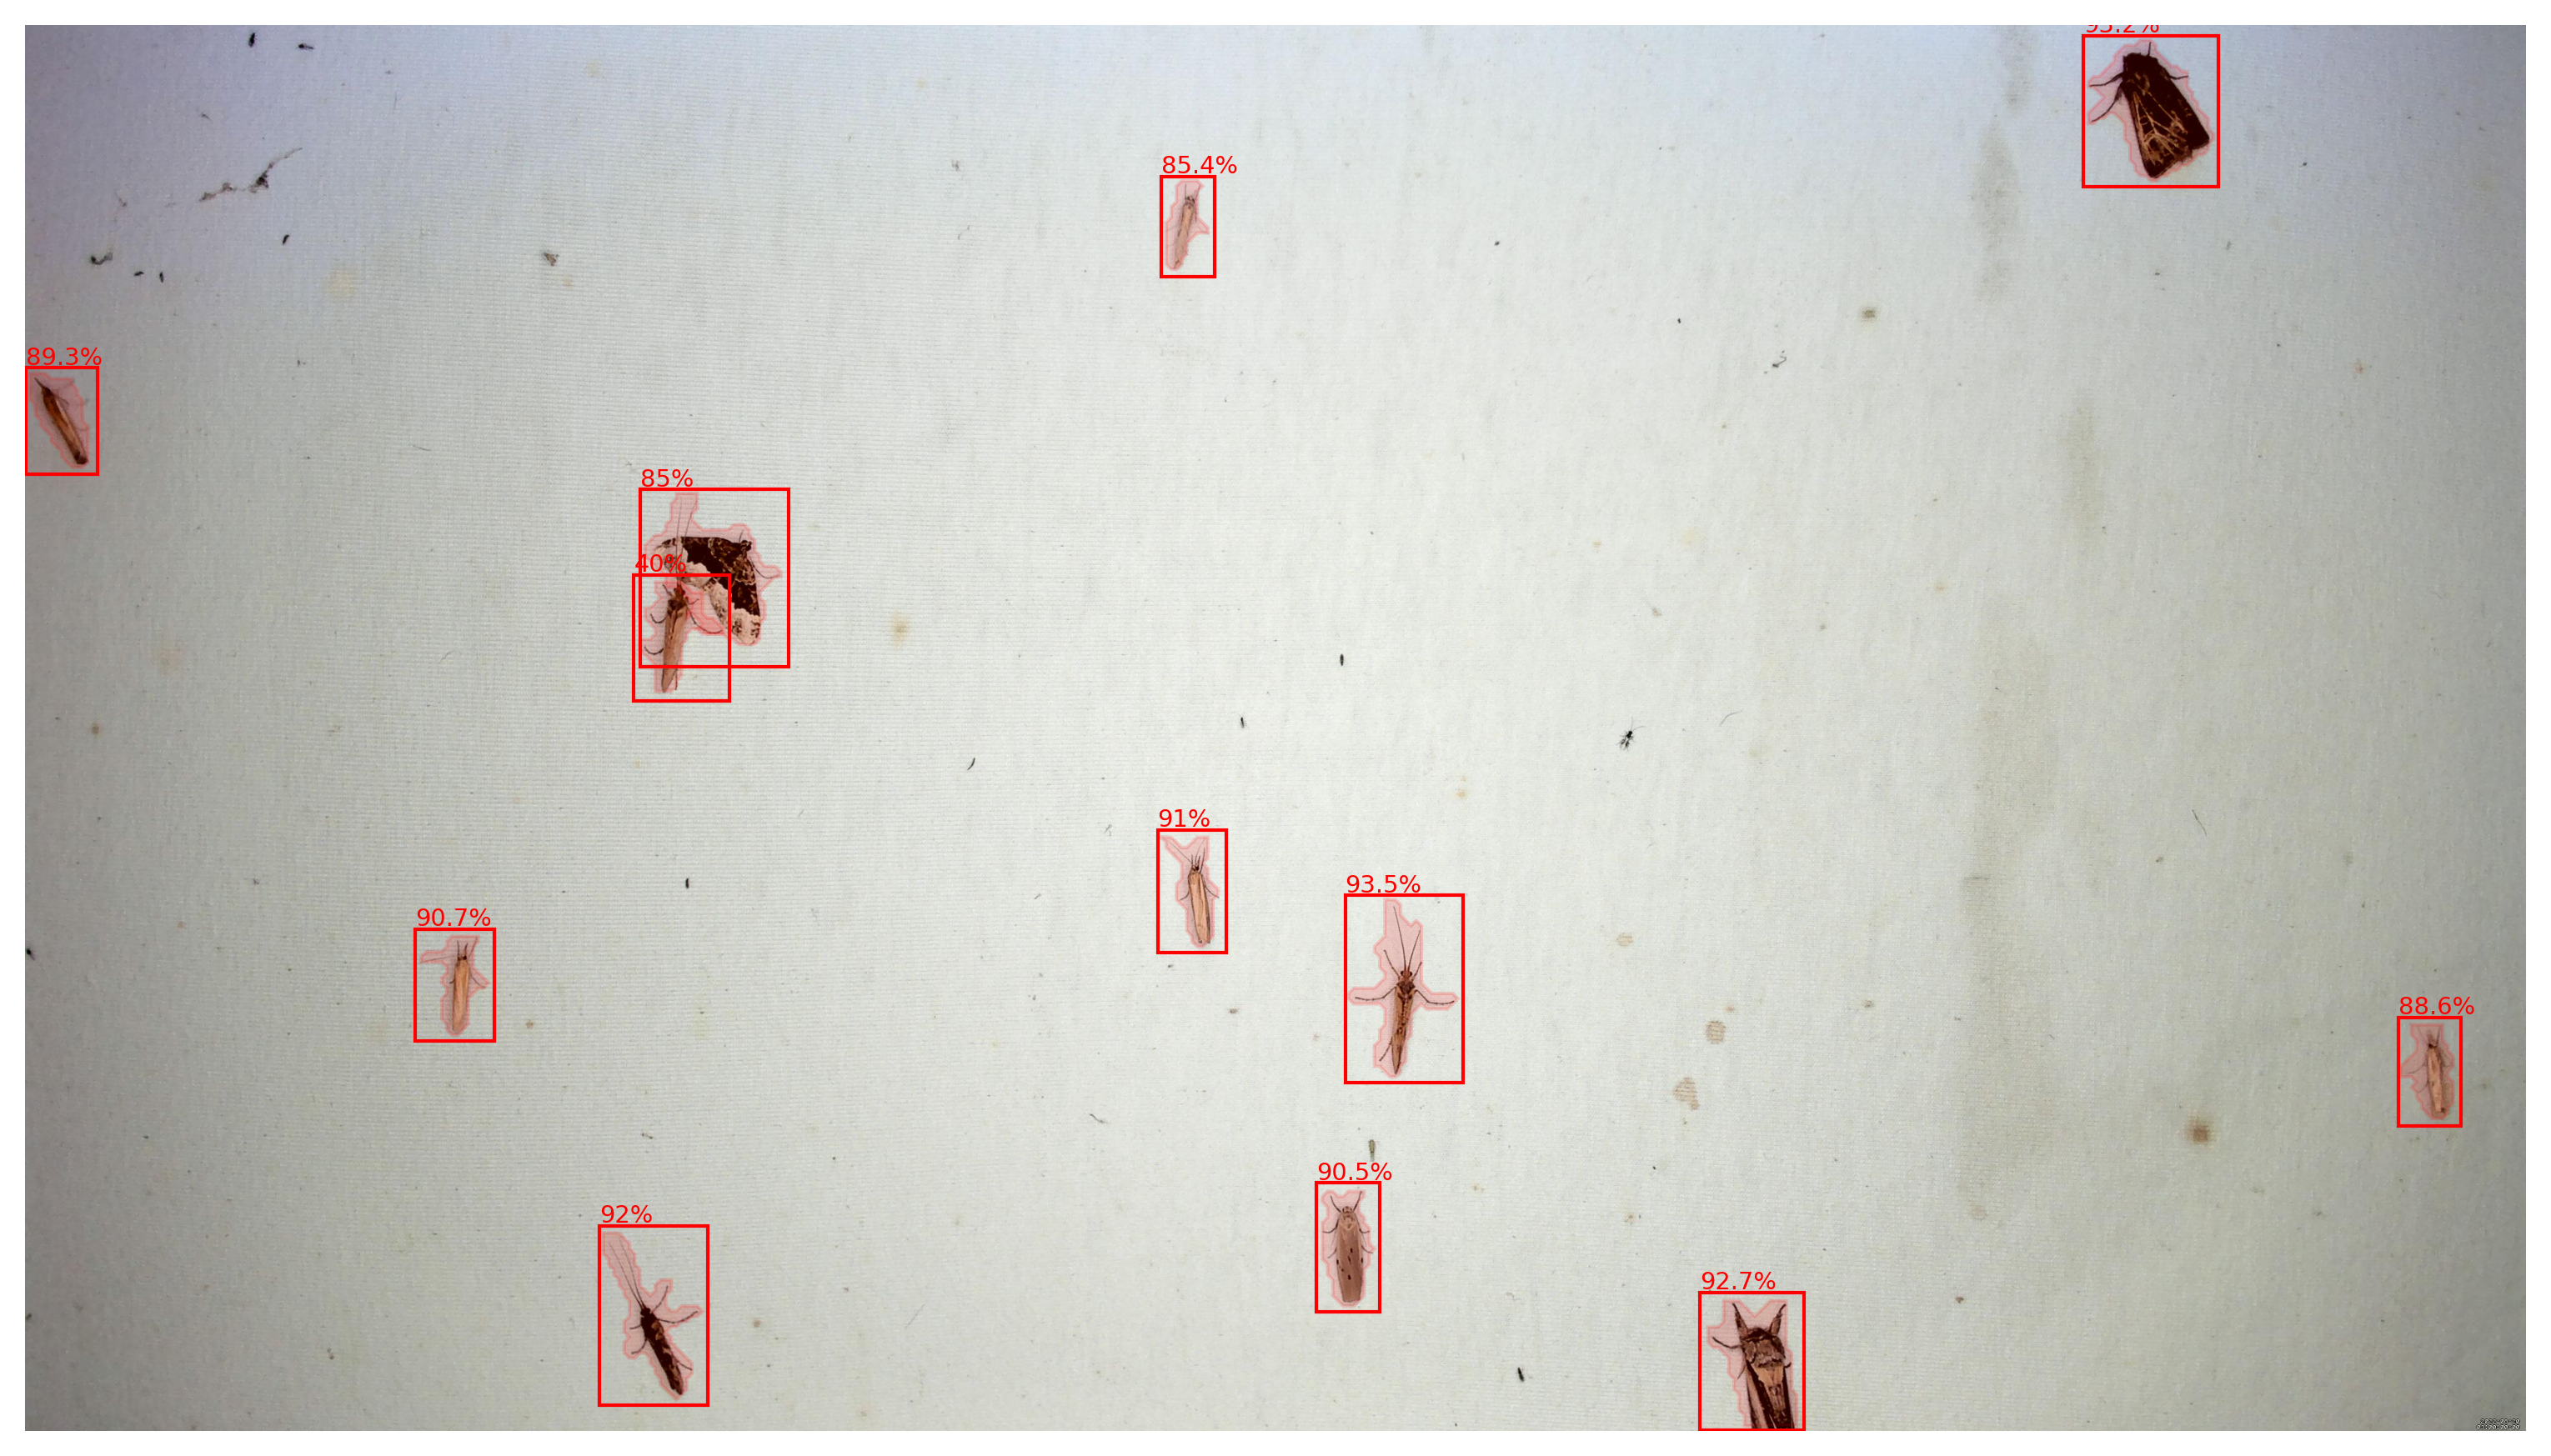

In [6]:
test.plot_matplotlib()

In [5]:
# test.plot(dpi=300, scale=1/2, outpath="test/test_plot.png")
test.plot_opencv(outpath="test/test_plot_opencv.png")

In [ ]:
def expand_with_neighbors(indices, mx, my):
    # Initialize a list to store the expanded indices
    expanded_indices = []

    # Define the relative positions of the neighbors
    neighbors = [(-1, -1), (-1, 0), (-1, 1), (0, -1), (0, 0), (0, 1), (1, -1), (1, 0), (1, 1)]

    # Iterate over each index pair and add its neighbors
    for x, y in indices:
        for dx, dy in neighbors:
            new_x, new_y = x + dx, y + dy
            new_x = min(max(new_x, 0), mx)
            new_y = min(max(new_y, 0), my)
            expanded_indices.append([new_x, new_y])

    # Convert the list of indices to a numpy array
    return np.array(expanded_indices)


In [ ]:
plt.figure(figsize=(10, 10))
ms = np.zeros(image.shape[1:]) # CxHxW
boxes = test._bboxes # x, y, w, h
print(ms.shape)
xys = np.concatenate(test.contours)
msx, msy = ms.shape
xys = expand_with_neighbors(expand_with_neighbors(xys, msy - 1, msx - 1), msy - 1, msx - 1)
ms[xys[:, 1], xys[:, 0]] = 1
# Permute to HxWxC (numpy)
# ms = ms.transpose(1, 2, 0)
plt.imshow(image.cpu().int().permute(1, 2, 0))
# plt.imshow(ms, alpha = .75)
for x, y, w, h in boxes:
    plt.gca().add_patch(mpl.patches.Rectangle((x, y), w, h, fill=False, edgecolor='r', linewidth=1))
plt.show()

In [ ]:
def intersect_test(rect1, rect2s, area_only=False, debug=False):
    """
    Calculates the intersection of a rectangle with a set of rectangles.
    """
    if len(rect1.shape) == 1 and not rect1.shape[0] == 4 or len(rect1.shape) == 2 and not rect1.shape[1] == 4:
        raise ValueError(f"Rectangles must be of shape (n, 4), not {rect1.shape}")
    if len(rect2s.shape) == 1 and not rect2s.shape[0] == 4 or len(rect2s.shape) == 2 and not rect2s.shape[1] == 4:
        raise ValueError(f"Rectangles must be of shape (n, 4), not {rect2s.shape}")
    if len(rect1.shape) == 1:
        rect1 = rect1.unsqueeze(0)
    if len(rect2s.shape) == 1:
        rect2s = rect2s.unsqueeze(0)

    # Safer to enable this, but it is slower
    # # Check the validity of the rectangles
    # if not check_bltr_validity(rect1, debug):
    #     rect1 = fix2btlr(rect1)
    # if not check_bltr_validity(rect2s, debug):
    #     rect2s = fix2btlr(rect2s)

    # Calculate vectors from each corner of rect1 to each corner of rect2s
    blbltrtr = rect2s - rect1
    bl_to_bl = blbltrtr[:, :2]
    tr_to_tr = blbltrtr[:, 2:] 
    bltrtrbl = rect2s[:, [2, 3, 0, 1]] - rect1
    bl_to_tr = bltrtrbl[:, :2]
    tr_to_bl = bltrtrbl[:, 2:]
    
    # Determine if each corner of rect1 is inside each rect2
    inside_tr = (tr_to_tr[:, 0] >= 0) & (tr_to_tr[:, 1] >= 0) & (tr_to_bl[:, 0] <= 0) & (tr_to_bl[:, 1] <= 0)
    inside_bl = (bl_to_bl[:, 0] <= 0) & (bl_to_bl[:, 1] <= 0) & (bl_to_tr[:, 0] >= 0) & (bl_to_tr[:, 1] >= 0)
    inside_tl = (bl_to_bl[:, 0] <= 0) & (tr_to_tr[:, 1] >= 0) & (bl_to_tr[:, 0] >= 0) & (tr_to_bl[:, 1] <= 0)
    inside_br = (tr_to_tr[:, 0] >= 0) & (bl_to_bl[:, 1] <= 0) & (tr_to_bl[:, 0] <= 0) & (bl_to_tr[:, 1] >= 0)

    # Check for enclosure
    enclosure = (rect1[:, :2] <= rect2s[:, :2]) & (rect1[:, 2:] >= rect2s[:, 2:])

    # Check for intersection with the "infinitely" extended cross of rect1
    in_cross = ((bl_to_bl[:, 0] <= 0) & (bl_to_tr[:, 0] >= 0)) | ((tr_to_tr[:, 0] >= 0) & (tr_to_bl[:, 0] <= 0)), ((bl_to_bl[:, 1] <= 0) & (bl_to_tr[:, 1] >= 0)) | ((tr_to_tr[:, 1] >= 0) & (tr_to_bl[:, 1] <= 0))

    # Check for equality - if equal, return the original rectangles
    zero = torch.tensor(0, dtype=rect1.dtype, device=rect1.device)
    is_equal = (bl_to_bl.isclose(zero).all(dim=1)) & (tr_to_tr.isclose(zero).all(dim=1))
    print(is_equal)

    # Check for no intersection - if no intersection, return the intersection rectangle [0, 0, 0, 0]
    is_intersecting = inside_tl | inside_br | inside_bl | inside_tr | (enclosure[:, 0] & in_cross[1]) | (enclosure[:, 1] & in_cross[0]) | (enclosure[:, 0] & enclosure[:, 1]) | is_equal

    if not area_only:
        intersections = is_intersecting.unsqueeze(1) * torch.cat((torch.max(rect1[:, :2], rect2s[:, :2]), torch.min(rect1[:, 2:], rect2s[:, 2:])), dim=1)
        intersections[is_equal] = rect1
    else:
        intersections = torch.zeros(rect2s.shape[0], dtype=rect1.dtype, device=rect1.device)
        intersections[is_intersecting] = (torch.min(rect1[:, 2:], rect2s[is_intersecting, 2:]) - torch.max(rect1[:, :2], rect2s[is_intersecting, :2])).abs().prod(dim=1)

    if debug:
        # Used for debugging
        return intersections, torch.stack((inside_tl, inside_tr, inside_br, inside_bl), dim=1), enclosure, in_cross
    else:
        return intersections

In [ ]:
# Example usage
r2 = torch.tensor([2, 2, 5, 5], dtype=dtype, device=device)  # Rectangle 2 coordinates

xmins = [1, 2, 3]
ymins = [1, 2, 3]
xmaxs = [4, 5, 6]
ymaxs = [4, 5, 6]

n_rects = len(xmins) * len(ymins) * len(xmaxs) * len(ymaxs)
ncols = min(6, int(n_rects ** (1/2)))
nrows = math.ceil(n_rects / ncols)

fig, axs = plt.subplots(nrows, ncols, figsize=(ncols * 2, nrows * 2))

rectangles = []

for xmin, ymin, xmax, ymax in itertools.product(xmins, ymins, xmaxs, ymaxs):
    r11 = torch.tensor([xmin, ymin, xmax, ymax], dtype=dtype, device=device)
    rectangles.append(r11.clone())

rectangles = torch.stack(rectangles)
rectangles = fix2btlr(rectangles)

intersections, corners, encs, crs = intersect_test(r2.unsqueeze(0), rectangles, debug=True)

# Move tensors to cpu and convert to float
rectangles = rectangles.detach().float().cpu().numpy()
intersections = intersections.detach().float().cpu().numpy()
corners = corners.detach().cpu()
encs = encs.detach().cpu()
crs = torch.stack(crs, dim=1).detach().cpu()
r2 = r2.detach().float().cpu().numpy()

for i, (ax, r1, inter) in enumerate(zip(axs.flatten(), rectangles, intersections)):
    # IOU
    a1 = (r1[2] - r1[0]) * (r1[3] - r1[1])
    a2 = (r2[2] - r2[0]) * (r2[3] - r2[1])
    ai = (inter[2] - inter[0]) * (inter[3] - inter[1])
    iou = ai / (a1 + a2 - ai)

    # Plot rect1
    p1 = mpl.patches.Rectangle((r1[0], r1[1]), r1[2] - r1[0], r1[3] - r1[1], linewidth=3, edgecolor="r", facecolor="none", alpha=1)
    # Plot rect2
    p2 = mpl.patches.Rectangle((r2[0], r2[1]), r2[2] - r2[0], r2[3] - r2[1], linewidth=3, edgecolor="b", facecolor="none", alpha=1)

    # Plot the intersection
    if inter.sum() > 0:
        p3 = mpl.patches.Rectangle((inter[0], inter[1]), inter[2] - inter[0], inter[3] - inter[1], linewidth=0, edgecolor="none", facecolor="g", alpha=0.5)
        ax.add_patch(p3)
        icenter = (inter[2:] + inter[:2]) / 2
        ax.text(icenter[0], icenter[1], f"{iou:.2f}", color="g", fontsize=12, ha="center", va="center")
    ax.add_patch(p1)
    ax.add_patch(p2)

    ax.set_xlim([0, 8])
    ax.set_ylim([0, 8])
    # ax.set_xticks([])
    # ax.set_yticks([])
    ax.set_title("i: " + str(i) + " | co: " + ",".join(["T" if c.item() else "F" for c in corners[i]]) + " | en: " +  ",".join(["T" if e.item() else "F" for e in encs[i]]) + " | cr: " +  ",".join(["T" if c.item() else "F" for c in crs[i]]), fontsize=11)

plt.tight_layout()
plt.show()


In [ ]:
# Test the non-max suppression function
def test_nms(n = 10, thresh=0.5):
    # Generate random boxes
    bxy = torch.rand(n, 2)
    bwh = torch.rand(n, 2) / 4
    boxes = torch.cat((bxy - bwh / 2, bxy + bwh / 2), dim=1)
    # Generate random scores
    scores = torch.rand(n)
    # Run the non-max suppression
    picked_boxes, picked_scores = non_max_suppression(boxes, scores, thresh)
    # Plot the boxes
    fig, ax = plt.subplots(1, figsize=(10, 10))
    for box, conf in zip(boxes, scores):
        rect = mpl.patches.Rectangle((box[0], box[1]), box[2] - box[0], box[3] - box[1], linewidth=1, edgecolor="none", facecolor="b", alpha=conf.item() / 3)
        ax.add_patch(rect)
    for box, score in zip(picked_boxes, picked_scores):
        rect = mpl.patches.Rectangle((box[0], box[1]), box[2] - box[0], box[3] - box[1], linewidth=3, edgecolor="r", facecolor="none", alpha=score.item() / 4)
        ax.add_patch(rect)
    plt.show()

    return boxes, scores

tb, ts = test_nms(1000, 0.05)

In [ ]:
tbi = intersect_rect_vectorized(tb[0].unsqueeze(0), tb[1:])

fig, ax = plt.subplots(1, figsize=(10, 10))

for i, (box, conf) in enumerate(zip(tb, ts)):
    if i == 0:
        continue
    rect = mpl.patches.Rectangle((box[0], box[1]), box[2] - box[0], box[3] - box[1], linewidth=1, edgecolor="none", facecolor="b", alpha=.1)
    ax.add_patch(rect)

tb1 = tb[0]
rect = mpl.patches.Rectangle((tb1[0], tb1[1]), tb1[2] - tb1[0], tb1[3] - tb1[1], linewidth=1, edgecolor="none", facecolor="g", alpha=.5)
ax.add_patch(rect)

for box in tbi:
    rect = mpl.patches.Rectangle((box[0], box[1]), box[2] - box[0], box[3] - box[1], linewidth=1, edgecolor="r", facecolor="none", alpha=1)
    ax.add_patch(rect)

plt.show()

In [ ]:
tb[0]